# Advanced Lane Finding
In order to manipulate a car I need to measure how much my lane is curving. To do that I need to map out the lanes in my camera image.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

def arrange_side_by_side(img1, img2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 30))
    ax1.imshow(img1)
    ax1.set_title(title1)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2)
    plt.show()

## Compute the Camera Calibration and Distortion Coefficients
Camera image has distortions. This means camera image does not represent perfectly real world objects. There is two types of distortion, Radial Distortion and Tangental Distortion.

To get a curvature of lane lines based on real world I need to correct those distortions, before I map out the lane lines from a camera image,.

To correct distortions I need to calculate some parameters.
 - distortion coefficients (k1, k2, p1, p2, k3)
 - camera matrix ([[fx, 0, xc], [0, fy, yc], [0, 0, 1]]) <= intrinsic parameters
 - extrinsic parameters (rotation and translation vector)
 
To find those parameters I'll do calibration through chessboard images.
 1. detect image points on 2D chessboard image space using findChessboardCorners() function
 2. prepare object points on 3D real world space which indicate same points with 1st step.
 3. get parameters for correcting image distortion using calibrateCamera() function.
 4. finally correct distortions using undistort() function.

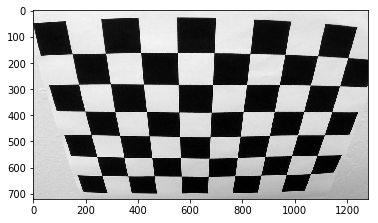

In [2]:
fname = 'camera_cal/calibration2.jpg'
img = mpimg.imread(fname)

img_origin = np.copy(img)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(img_gray, cmap='gray')

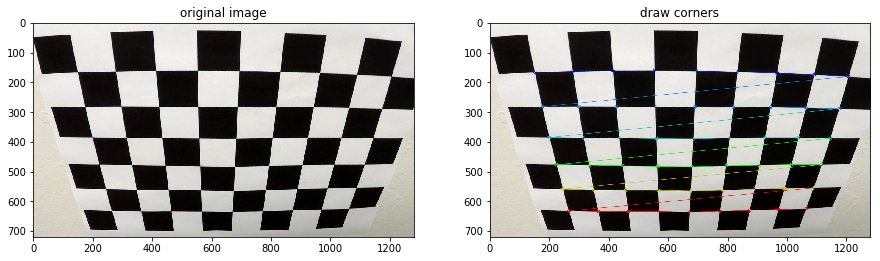

In [3]:
# 1st step: find image points on 2D chessboard image
pattern_size = (9, 6)
found, image_points_base = cv2.findChessboardCorners(img_gray, pattern_size, None)

# checking
cv2.drawChessboardCorners(img, pattern_size, image_points_base, found)
arrange_side_by_side(img_origin, img, 'original image', 'draw corners')

In [4]:
# 2nd step: prepare object points
object_points_base = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
object_points_base[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape((-1, 2))

# x = np.arange(pattern_size[0])
# y = np.arange(pattern_size[1])
# xx, yy = np.meshgrid(x,y)
# object_points_base = [[xx[i][j], yy[i][j], 0] for j in range(pattern_size[0]) for i in range(pattern_size[1])]

object_points = []
image_points = []

if found:
    object_points.append(object_points_base)
    image_points.append(image_points_base)

In [5]:
# 3rd step: calibrate camera to get parameters for undistortion
try:
    r, cam_mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img.shape[1::-1], None, None)
except:
    print('Exception occured at calibrateCamera function!!\nPlease check the parameters.')

In [6]:
# 4th step: Undistortion
undist_img = cv2.undistort(img_origin, cam_mtx, dist_coeff)

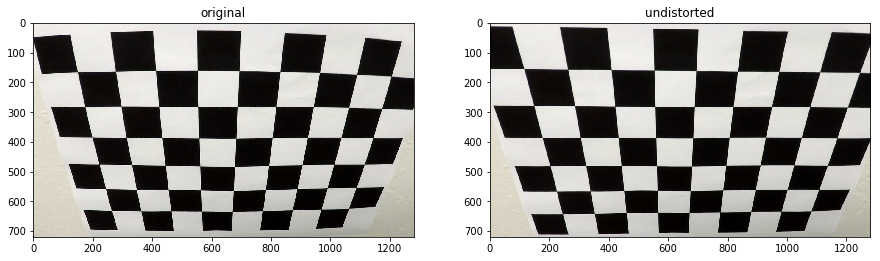

In [7]:
# See the result
arrange_side_by_side(img_origin, undist_img, 'original', 'undistorted')

In [8]:
def calibrate_camera(fnames, pattern_size, criteria):
    # Prepare the object points(3D real world coordinate)
    obj_points = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
    obj_points[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape((-1, 2))

    object_points = []
    image_points = []
    for fname in fnames:
        img = mpimg.imread(fname)
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        found, img_points = cv2.findChessboardCorners(img_gray, pattern_size, None)
    
        if found:
            cv2.cornerSubPix(img_gray,img_points,(11,11),(-1,-1),criteria)
            object_points.append(obj_points)
            image_points.append(img_points)
    #    img = cv2.drawChessboardCorners(img, pattern_size, img_points, found)
    #    cv2.imshow('img', img)
    #    cv2.waitKey(500)
    #cv2.destroyAllWindows()
    return cv2.calibrateCamera(object_points, image_points, img.shape[1::-1], None, None)

In [9]:
# camera calibration
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
fnames = glob.glob('camera_cal/*.jpg')
pattern_size = (9, 6)
ret, cam_mtx, dist_coeff, rvecs, tvecs = calibrate_camera(fnames, pattern_size, criteria)

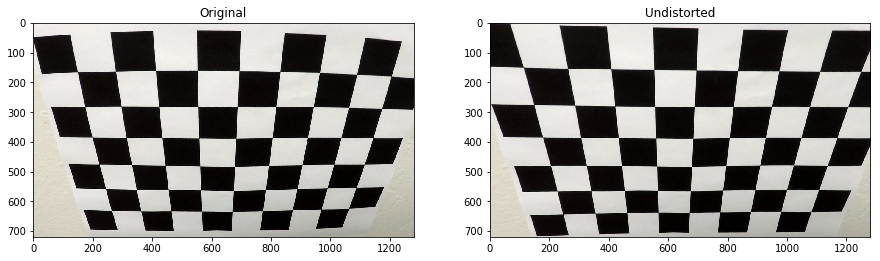

In [10]:
# correct distortion of chessboard image
img = mpimg.imread('camera_cal/calibration2.jpg')
undist_img = cv2.undistort(img, cam_mtx, dist_coeff)
arrange_side_by_side(img, undist_img, 'Original', 'Undistorted')

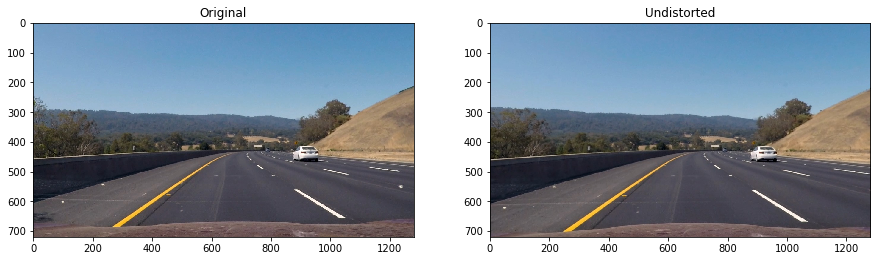

In [11]:
# correct distortion of road image
rimg = mpimg.imread('test_images/test3.jpg')
undist_rimg = cv2.undistort(rimg, cam_mtx, dist_coeff)
arrange_side_by_side(rimg, undist_rimg, 'Original', 'Undistorted')

## Create Thresholded Binary Image

In [12]:
def filter_sobel(img, orientation='x'):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orientation == 'x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
    elif orientation == 'y':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)
    else:
        print("Unknown value of orientation.")
        return None
    abs_img = np.absolute(sobel)
    return abs_img * 255 / np.max(abs_img)

def filter_sobel_gradient_magnitude(img, ksize=3):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    return grad_mag * 255 / np.max(grad_mag)

def filter_gradient_direction(img, ksize=3):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize))
    abs_sobely = np.absolute(cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize))
    return np.arctan2(abs_sobely, abs_sobelx)
    
def filter_hls(rgb_img, channel='s'):
    if channel == 'h':
        c = 0
    elif channel == 'l':
        c = 1
    elif channel == 's':
        c = 2
    else:
        print("Undefined parameter channel")
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    return hls[:,:,c]

def create_binary_image(img, thresh_min=50, thresh_max=100):
    binary = np.zeros_like(img)
    binary[(img > thresh_min) & (img < thresh_max)] = 1
    return binary

In [13]:
# apply the Sobel filter for y direction
#sobelx = filter_sobel(rimg, 'x')
#binary_sobelx = create_binary_image(sobelx, 15, 140)
#
#arrange_side_by_side(rimg, binary_sobelx, 'Origin', 'BinaryX')

In [14]:
# apply the Sobel filter for y direction
#sobely = filter_sobel(rimg, 'y')
#binary_sobely = create_binary_image(sobely, 20, 150)
#
#arrange_side_by_side(rimg, binary_sobely, 'Origin', 'Binary')

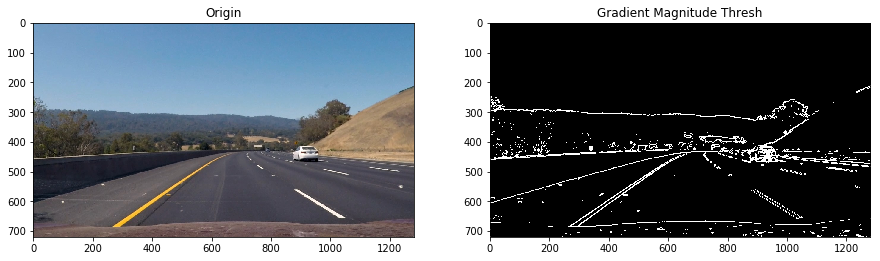

In [15]:
grad_mag = filter_sobel_gradient_magnitude(rimg, ksize=5)
binary_grad_mag = create_binary_image(grad_mag, 30, 170)

arrange_side_by_side(rimg, binary_grad_mag, 'Origin', 'Gradient Magnitude Thresh')

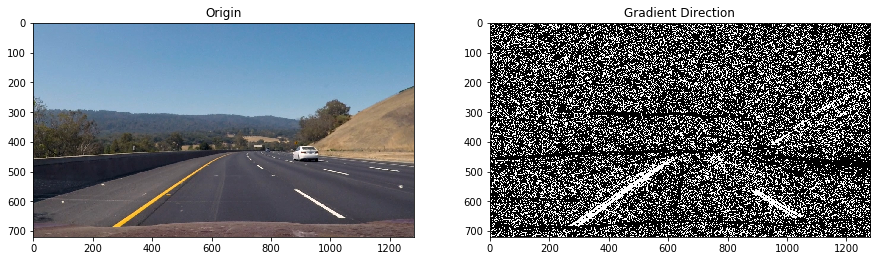

In [16]:
grad_dir = filter_gradient_direction(rimg, ksize=11)
binary_grad_dir = create_binary_image(grad_dir, 0.75, 1.2)

arrange_side_by_side(rimg, binary_grad_dir, 'Origin', 'Gradient Direction')

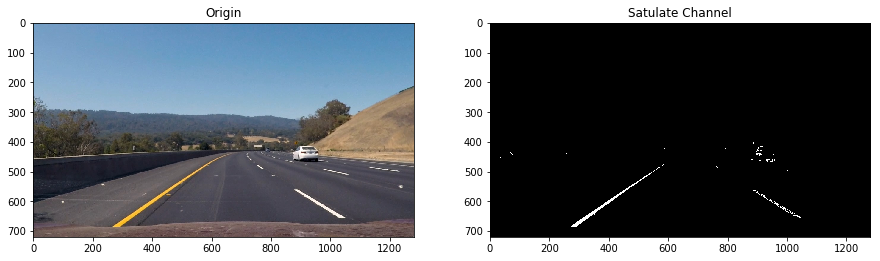

In [17]:
s_img = filter_hls(rimg, 's')
binary_satulate = create_binary_image(s_img, 200, 300)
arrange_side_by_side(rimg, binary_satulate, 'Origin', 'Satulate Channel')

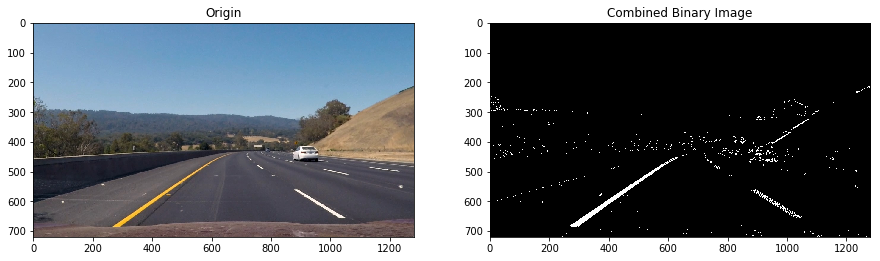

In [23]:
# Combine the above binary images
binary = np.zeros_like(binary_grad_dir)
binary[((binary_grad_mag == 1) & (binary_grad_dir == 1) | (binary_satulate == 1))] = 1

arrange_side_by_side(rimg, binary, 'Origin', 'Combined Binary Image')

## Apply Perspective Transform

In [19]:
#%matplotlib qt
%matplotlib inline

src = np.float32(
    [[840, 546],
     [1051, 677],
     [244, 686],
     [453, 546]])
dst = np.float32(
    [[1051, 463],
     [1051, 686],
     [245, 686],
     [245, 463]])

M = cv2.getPerspectiveTransform(src, dst)

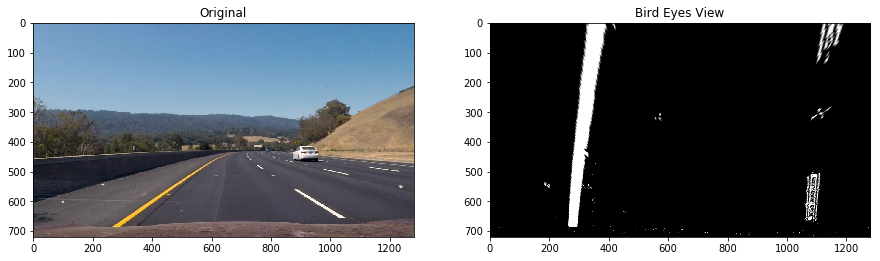

In [24]:
warped = cv2.warpPerspective(binary, M, (rimg.shape[1], rimg.shape[0]), flags=cv2.INTER_LINEAR)

arrange_side_by_side(rimg, warped, 'Original', 'Bird Eyes View')

## Sliding Windows to plot lines

In [26]:
def get_starting_point_likely(img):
    hist = np.sum(img[img.shape[0]//2:, :], axis=0)
    center_horizontal = img.shape[1]//2
    left = np.argmax(hist[:center_horizontal])
    right = np.argmax(hist[center_horizontal:]) + center_horizontal
    return left, right

def get_lane_line_pixels(img):
    margin = 100
    n_window = 9
    minpix_thresh = 50
    
    lp_current, rp_current = get_starting_point_likely(img)
    
    nonzero = img.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])

    # output place holders
    left_lane_pixels = []
    right_lane_pixels = []
    out_img = np.dstack((img, img, img)) * 255
    
    for i in range(n_window):
        bottom = img.shape[0] - img.shape[0]//n_window * i
        top = bottom - img.shape[0]//n_window
        l_left = lp_current - margin
        l_right = lp_current + margin
        r_left = rp_current - margin
        r_right = rp_current + margin
        
        cv2.rectangle(out_img, (l_left, top), (l_right, bottom), (0,255,0), 2)
        cv2.rectangle(out_img, (r_left, top), (r_right, bottom), (0,255,0), 2)
        
        left_inds = ((nonzero_y > top) & (nonzero_y < bottom) & (nonzero_x > l_left) & (nonzero_x < l_right)).nonzero()[0]
        right_inds = ((nonzero_y > top) & (nonzero_y < bottom) & (nonzero_x > r_left) & (nonzero_x < r_right)).nonzero()[0]
        left_lane_pixels.append(left_inds)
        right_lane_pixels.append(right_inds)
        
        if len(left_inds > minpix_thresh):
            lp_current = np.int(np.mean(nonzero_x[left_inds]))
        if len(right_inds > minpix_thresh):
            rp_current = np.int(np.mean(nonzero_x[right_inds]))
            
    try:
        left_lane_pixels = np.concatenate(left_lane_pixels)
        right_lane_pixels = np.concatenate(right_lane_pixels)
    except ValueError:
        pass
    
    lx = nonzero_x[left_lane_pixels]
    ly = nonzero_y[left_lane_pixels]
    rx = nonzero_x[right_lane_pixels]
    ry = nonzero_y[right_lane_pixels]
    
    out_img[ly, lx] = [255, 0, 0]
    out_img[ry, rx] = [0, 0, 255]
    
    return lx, ly, rx, ry ,out_img

def get_quadratic_plots(img, quad_coef_l, quad_coef_r):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    try:
        plotx_l = quad_coef_l[0]*ploty**2 + quad_coef_l[1]*ploty + quad_coef_l[2]
        plotx_r = quad_coef_r[0]*ploty**2 + quad_coef_r[1]*ploty + quad_coef_r[2]
    except TypeError:
        plotx_l = 1*ploty**2 + 1*ploty
        plotx_r = 1*ploty**2 + 1*ploty
    return ploty, plotx_l, plotx_r

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    coefs_l = np.polyfit(ly, lx, 2)
    coefs_r = np.polyfit(ry, rx, 2)
    return get_quadratic_plots(warped, coefs_l, coefs_r)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 0)

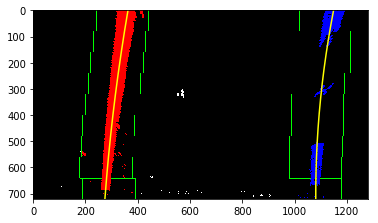

In [27]:
lx, ly, rx, ry, rect_drawed = get_lane_line_pixels(warped)
ploty, plotx_l, plotx_r = fit_poly(warped.shape,lx, ly, rx, ry)

plt.imshow(rect_drawed)
plt.plot(plotx_l, ploty, color='yellow')
plt.plot(plotx_r, ploty, color='yellow')
plt.xlim(0, rect_drawed.shape[1])
plt.ylim(rect_drawed.shape[0], 0)

## Use the previous polynomial to skip the sliding window
So far I did the blind search. However using the full alforithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.

Instead I can just search in a margin around the previous lane line position. So, once I know where the lines are in one frame of video I can do a highly targeted search for them in the next frame.

And this way should help me track the lanes through sharp curves and tricky conditions. If I lose track of the lines, go back to my sliding windos search or other method to rediscover them.

To hold the pixel values contained within the boundaries of a given sliding window I used the variables called <code>left_lane_pixels</code> and <code>right_lane_pixels</code>. This time, we'll take the polynomial functions I fit before, along with a hyperparameter <code>margin</code>, to determine whivh activated pixcels fall into the green shaded areas from the avobe image.

To implement this, I'll want to grab only those pixels with x values that are +/- my margin from my polynomial lines.